In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

font = {'size'   : 20}
matplotlib.rc('font', **font)

# Problem: radioactive decay

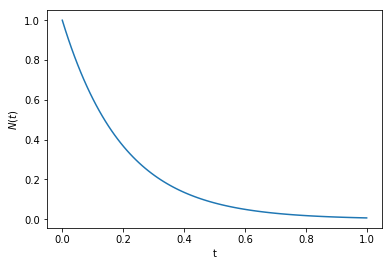

In [2]:
t = np.linspace(0, 1, 100)
λ = 5.0
N = lambda t: np.exp(-λ*t)
plt.plot(t, N(t))
plt.xlabel("t")
plt.ylabel("$N(t)$")

## Solving problem with Euler method

In [4]:
hist = []
# fixed grid
num_steps = 50
Δt = 1/num_steps
# initial condition
Nk = 1.0;
tk  = 0.0
# integration
hist.append((tk, Nk))
for k in range(num_steps):
    Nk = Nk - λ * Δt * Nk
    tk  = tk + Δt
    hist.append((tk, Nk))

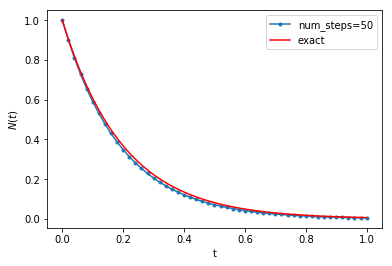

In [5]:
plt.plot(*np.array(hist).T, '.-', label='num_steps=50')
plt.plot(t, N(t), 'r', label='exact')
plt.xlabel("t")
plt.ylabel("$N(t)$")
plt.legend()

## Refactoring code - towards black-box solver

In [6]:
def g_fn(tk, hk):
    return - λ * hk

def euler_step(dt, tk, hk, fun):
    return hk + dt * fun(tk, hk)

In [7]:
hist = []
# fixed grid
num_steps = 50
Δt = 1/num_steps
# initial condition
Nk = 1.0;
tk  = 0.0
# integration
hist.append((tk, Nk))
for k in range(num_steps):
    Nk = euler_step(Δt, tk, Nk, g_fn)
    tk  = tk + Δt
    hist.append((tk, Nk))

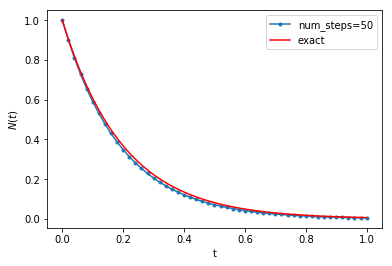

In [8]:
plt.plot(*np.array(hist).T, '.-', label='num_steps=50')
plt.plot(t, N(t), 'r', label='exact')
plt.xlabel("t")
plt.ylabel("$N(t)$")
plt.legend()

## Simple black box solver - ODEINT function

In [9]:
def odeint(func, y0, t, solver):
    Δts = t[1:] - t[:-1]
    tk = t[0]
    yk = y0
    hist = [(tk, y0)]
    for Δt in Δts:
        yk = solver(Δt, tk, yk, func)
        tk = tk + Δt
        hist.append((tk, yk))
    return hist

In [10]:
hist = odeint(
    func=g_fn, 
    y0=1.0, 
    t=np.linspace(0, 1, 50), 
    solver=euler_step
)

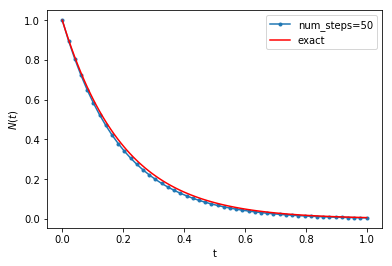

In [11]:
plt.plot(*np.array(hist).T, '.-', label='num_steps=50')
plt.plot(t, N(t), 'r', label='exact')
plt.xlabel("t")
plt.ylabel("$N(t)$")
plt.legend()

## Higher order solve - midpoint method

In [12]:
def midpoint_step(Δt, tk, hk, fun):
    k1 = fun(tk, hk)
    k2 = fun(tk + Δt, hk + Δt * k1)
    return hk + Δt * (k1 + k2) / 2

In [13]:
t_grid = np.linspace(0, 1, 15)
hist_euler = odeint(g_fn, 1.0, t_grid, euler_step)
hist_midpoint = odeint(g_fn, 1.0, t_grid, midpoint_step)

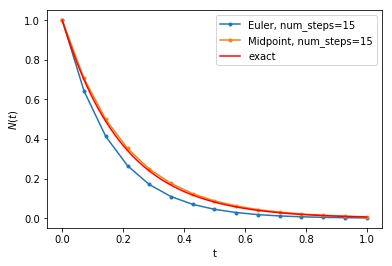

In [14]:
plt.plot(*np.array(hist_euler).T, '.-', label='Euler, num_steps=15')
plt.plot(*np.array(hist_midpoint).T, '.-', label='Midpoint, num_steps=15')
plt.plot(t, N(t), 'r', label='exact')
plt.xlabel("t")
plt.ylabel("$N(t)$")
plt.legend()

# Integrating Neural Network

In [210]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
tf.enable_eager_execution()
keras = tf.keras

def midpoint_step_keras(Δt, tk, hk, fun):
    k1 = fun([tk, hk])
    k2 = fun([tk + Δt, hk + Δt * k1])
    return hk + Δt * (k1 + k2) / 2

class Module(keras.Model):
    def __init__(self, nf):
        super(Module, self).__init__()        
        self.dense_1 = Dense(nf, activation='tanh')
        self.dense_2 = Dense(nf, activation='tanh')

    def call(self, inputs, **kwargs):
        t, x = inputs
        h = self.dense_1(x)
        return self.dense_2(h) - 0.25 * x

In [211]:
model = Module(2)

In [218]:
t_grid = np.linspace(0, 500., 2000)
h0 = tf.to_float([[1.0, -1.0]])
model = Module(2)
hist = odeint(model, h0, t_grid, midpoint_step_keras)

In [219]:
h_hist = np.array([h.numpy()[0, :] for t, h in hist])

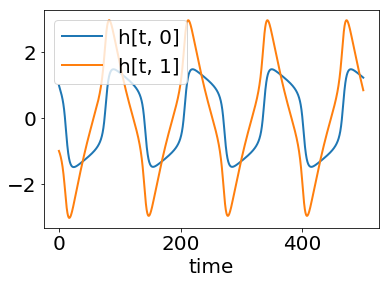

In [220]:
plt.plot(t_grid, h_hist[:, 0], label="h[t, 0]", lw=2)
plt.plot(t_grid, h_hist[:, 1], label="h[t, 1]", lw=2)
plt.xlabel("time")
plt.legend()

In [221]:
# Cherry picked result :)